### Number of serial interval samples

When a distribution expressing uncertainty in the serial intervals is available, our inference procedure uses some number of samples from that distribution to approximate the posterior of $R_t$.

The purpose of this notebook is to study the effect of the number of serial interval samples on the $R_t$ posterior, in order to select an acceptable number.

It uses the Ontario COVID-19 data.

In [1]:
# Import libraries
import branchpro
import numpy as np
from matplotlib import pyplot as plt
import os
import pandas as pd

In [2]:
# Read serial interval
si_file = 'si-epinow'
path = os.path.join('../data_library/serial_interval', '{}.csv'.format(si_file))
serial_interval = pd.read_csv(path, header=None)
serial_interval = serial_interval.fillna(0)
serial_intervals = serial_interval.values.T

In [3]:
# Read Ontario data
path = os.path.join('../data_library/covid_ontario/ON.csv')
data = pd.read_csv(path)[:51]

In [4]:
# Inference parameters and data
time_key = 'Time'
num_timepoints = max(data[time_key])
data_times = data[time_key]

locally_infected_cases = data['Incidence Number']
imported_cases = data['Imported Cases']

start_times = np.arange(1, num_timepoints+1, dtype=int)
times = np.arange(num_timepoints+1)

tau = 6
R_t_start = tau+1
a = 1
b = 0.2

inc_data = pd.DataFrame(
    {
        'Time': start_times,
        'Incidence Number': locally_infected_cases
    }
)

imported_inc_data = pd.DataFrame(
    {
        'Time': start_times,
        'Incidence Number': imported_cases
    }
)

We perform inference for $R_t$ using various numbers of serial intervals samples. The posterior for $R_t$ at the sixth time point is extracted.

In [5]:
nums_si = [2, 5, 10, 15, 20, 50, 
           100, 150, 200, 300, 400, 
           500, 600, 700, 800, 900, 1000]
lower_values = []
upper_values = []
median_values = []
time_idx = 6

for num_serial_intervals in nums_si:
    subset_serial_intervals = serial_intervals[:num_serial_intervals, :]
    
    inference = branchpro.LocImpBranchProPosteriorMultSI(
        inc_data=inc_data,
        imported_inc_data=imported_inc_data,
        epsilon=1,
        daily_serial_intervals=subset_serial_intervals,
        alpha=a,
        beta=b)

    inference.run_inference(tau=tau)
    intervals = inference.get_intervals(central_prob=.95)
    
    lower_values.append(intervals['Lower bound CI'][time_idx])
    upper_values.append(intervals['Upper bound CI'][time_idx])
    median_values.append(intervals['Median'][time_idx])


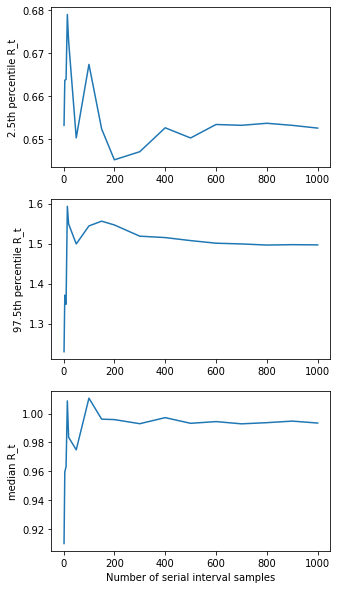

In [6]:
fig = plt.figure(figsize=(5, 10))

ax = fig.add_subplot(3, 1, 1)
ax.plot(nums_si, lower_values)
ax.set_ylabel('2.5th percentile R_t')

ax = fig.add_subplot(3, 1, 2)
ax.plot(nums_si, upper_values)
ax.set_ylabel('97.5th percentile R_t')

ax = fig.add_subplot(3, 1, 3)
ax.plot(nums_si, median_values)
ax.set_ylabel('median R_t')
ax.set_xlabel('Number of serial interval samples')

plt.show()

The results above suggest that 1000 samples is sufficient to obtain an accurate posterior.